In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler

# Read the CSV files into dfs
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

# Merge the dfs on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

# Print the merged df
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(9813, 1389)


In [297]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSPREP', 'DIQ010','PAQ650', 'PAQ665', 'ALQ101','ALQ151', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD641', 'SMD650', 'SMD030'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,SMQ040,DBQ700,HSD010,SMQ050Q,SMQ050U,SMD055,SMD057,SMD641,SMD650,SMD030
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,2.0,2.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,2.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,3.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0


In [298]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)
df.loc[df['ALQ120Q'] == 0, ['ALQ130']] = df.loc[df['ALQ120Q'] == 0, ['ALQ130']].fillna(0)

df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)

df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

In [299]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSPREP': 'SaltFreq',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ120U' : 'UnitAlc',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'SMD030' : 'AgeStartedSmokingReg',
    'SMQ050Q': 'TimeQuit',
    'SMD055': 'AgeLastSmokedReg',
    'SMD057': 'WhenSmokedCigs/Day',
    'SMD641': 'DaysSmokedInLast30',
    'SMD650': 'AvgCigs/DayInLast30'
}

df.rename(columns=new_column_names, inplace=True)


In [300]:
def plot_bivariate(col, hue):
    if df[col].nunique() > 5:
        plt.figure(figsize=(20, 10))
        rot = 90
    else:
        plt.figure(figsize=(10, 7))
        rot = 0

    def percentage(ax):
        heights = [[p.get_height() for p in bars] for bars in ax.containers]  # Get the counts of each bar, make arrays when more than one in group
        min_length = min(len(group) for group in heights)  # Find the minimum length of the groups
        for bars in ax.containers:
            for i, p in enumerate(bars):
                if i >= min_length:
                    continue  # Skip if index is out of range for any group
                total = sum(group[i] for group in heights)  # Sum total of each group
                percentage = (100 * p.get_height() / total)  # Calculate % to annotate
                ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() * 0.5, 0.8 * p.get_height()), 
                            ha='center', va='bottom', rotation=0)
                if percentage > 25.0:
                    percentage = f'{percentage:.1f}%'
                    ax.annotate(percentage, (p.get_x() + p.get_width() * 0.5, 0.25 * p.get_height()), 
                                ha='center', va='center', rotation=rot)

    plot = sns.countplot(x=df[col], hue=df[hue], palette='pastel')
    percentage(plot)
    plt.xticks(rotation=rot)
    plt.show()

In [301]:
def calculate_average(df, features, new_feature_name):
    # Check and select the relevant columns from the df
    relevant_columns = df[features].replace({0: np.nan})  # Replace zeros with NaN to exclude from mean calculation
    
    # Calculate the mean across the specified columns, ignoring NaN values
    df[new_feature_name] = relevant_columns.mean(axis=1, skipna=True)

In [302]:
diasBP_features = ['DiasBP1', 'DiasBP2', 'DiasBP3']
sysBP_features = ['SysBP1', 'SysBP2', 'SysBP3']

calculate_average(df, diasBP_features, 'AvgDiasBP')
calculate_average(df, sysBP_features, 'AvgSysBP')

In [303]:
# Drop rows where AvgSysBP is null
df = df.dropna(subset=['AvgSysBP'])

In [304]:

conditions = [
    df['AvgSysBP'] < 130,
    (df['AvgSysBP'] >= 130)
]
values = [0, 1]

# Use np.select to handle NaNs and assign the appropriate category
df['HypertensionLvl'] = np.select(conditions, values, default=np.nan)

In [305]:
df.loc[df['TimeQuit'] == 66666, 'TimeQuit'] = 50

In [306]:
# Define the transformation function
def transform_time_quit(row):
    if row['SMQ050U'] == 1:
        return 0
    elif row['SMQ050U'] == 2:
        return (row['TimeQuit'] / 52)
    elif row['SMQ050U'] == 3:
        return (row['TimeQuit'] / 12)
    else:
        return row['TimeQuit']

# Apply the transformation to the TimeQuit column
df['TimeQuit'] = df.apply(transform_time_quit, axis=1)

In [307]:
# Update AgeLastSmokedReg where it is null, TimeQuit is not null, and TimeQuit is smaller than 100
df.loc[(df['AgeLastSmokedReg'].isnull()) & (df['TimeQuit'].notnull()) & (df['TimeQuit'] < 100) & (df['Smoker'] == 3) & (df['100Cigs'] == 1), 'AgeLastSmokedReg'] = df['Age'] - df['TimeQuit']

In [308]:
df.loc[df['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan
df.loc[df['TimeQuit'] > 66666, 'TimeQuit'] = np.nan
df.loc[df['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan
df = df.drop(columns=['SMQ050U'])

df['yearsSmoked'] = np.where(
    df['Smoker'].isin([1, 2]),
    df['Age'] - df['AgeStartedSmokingReg'],
    df['AgeLastSmokedReg'] - df['AgeStartedSmokingReg']
)

df['yearsSmoked'] = df['yearsSmoked'].fillna(0)

C:\Users\samco\AppData\Local\Temp\ipykernel_11212\3170566072.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


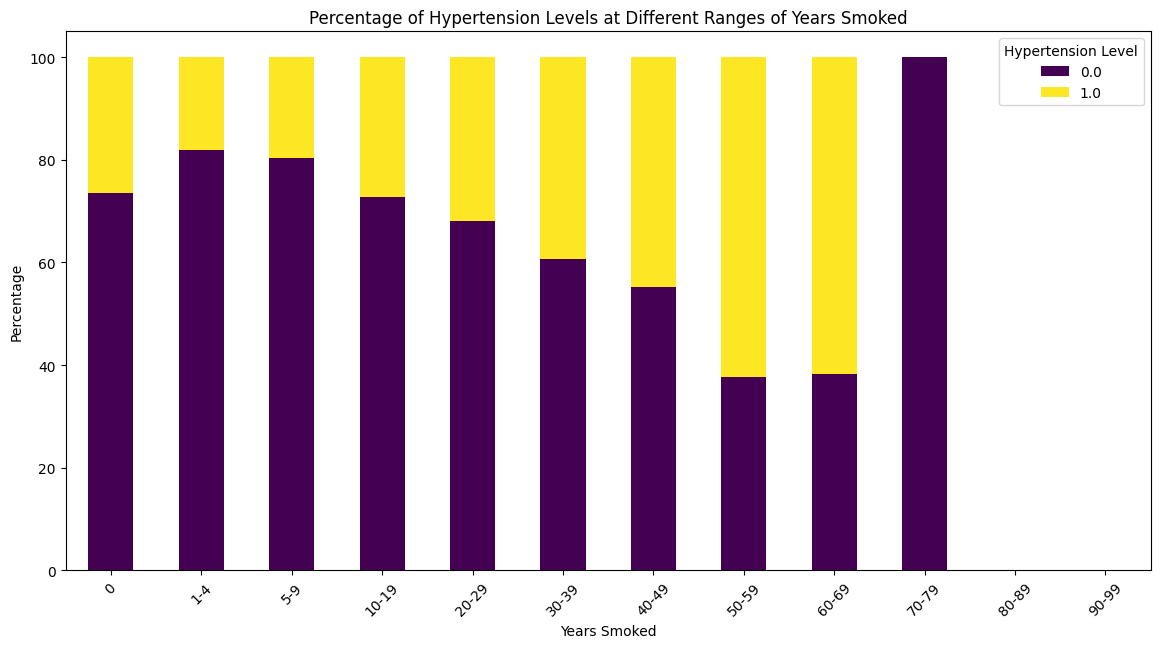

In [309]:
# Bin the yearsSmoked values
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['yearsSmokedBinned'] = pd.cut(df['yearsSmoked'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Years Smoked')
plt.xlabel('Years Smoked')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

In [310]:
# Define the transformation function
def calculate_lifetime_cigarettes(row):
    if row['Smoker'] == 3:
        if pd.isnull(row['WhenSmokedCigs/Day']) | (row['WhenSmokedCigs/Day'] > 100):
            return 0
        return row['yearsSmoked'] * row['WhenSmokedCigs/Day'] * 365
    elif row['Smoker'] in [1, 2]:
        if pd.isnull(row['AvgCigs/DayInLast30']) | (row['AvgCigs/DayInLast30'] > 100):
            return 0
        return row['yearsSmoked'] * row['AvgCigs/DayInLast30'] * row['DaysSmokedInLast30'] /30 * 365
    else:
        return np.nan

# Apply the transformation to create the lifetimeCigarettes feature
df['lifetimeCigarettes'] = df.apply(calculate_lifetime_cigarettes, axis=1)

# Verify the changes
print(df[['Smoker', 'yearsSmoked', 'WhenSmokedCigs/Day', 'AvgCigs/DayInLast30', 'DaysSmokedInLast30', 'lifetimeCigarettes']].head(20))

    Smoker  yearsSmoked  WhenSmokedCigs/Day  AvgCigs/DayInLast30  \
0      3.0    49.000000                 2.0                  NaN   
1      2.0    54.000000                 NaN                  1.0   
2      3.0     6.000000                 3.0                  NaN   
4      3.0     0.000000                 NaN                  NaN   
5      3.0    22.000000                 5.0                  NaN   
7      3.0     0.000000                 NaN                  NaN   
8      1.0    23.000000                 NaN                  1.0   
9      1.0    44.000000                 NaN                 25.0   
10     3.0     0.000000                 NaN                  NaN   
12     3.0     0.000000                 NaN                  NaN   
15     3.0     0.000000                 NaN                  NaN   
18     3.0    21.333333                20.0                  NaN   
19     3.0     0.000000                 NaN                  NaN   
21     3.0     0.000000                 NaN     

C:\Users\samco\AppData\Local\Temp\ipykernel_11212\2307530192.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


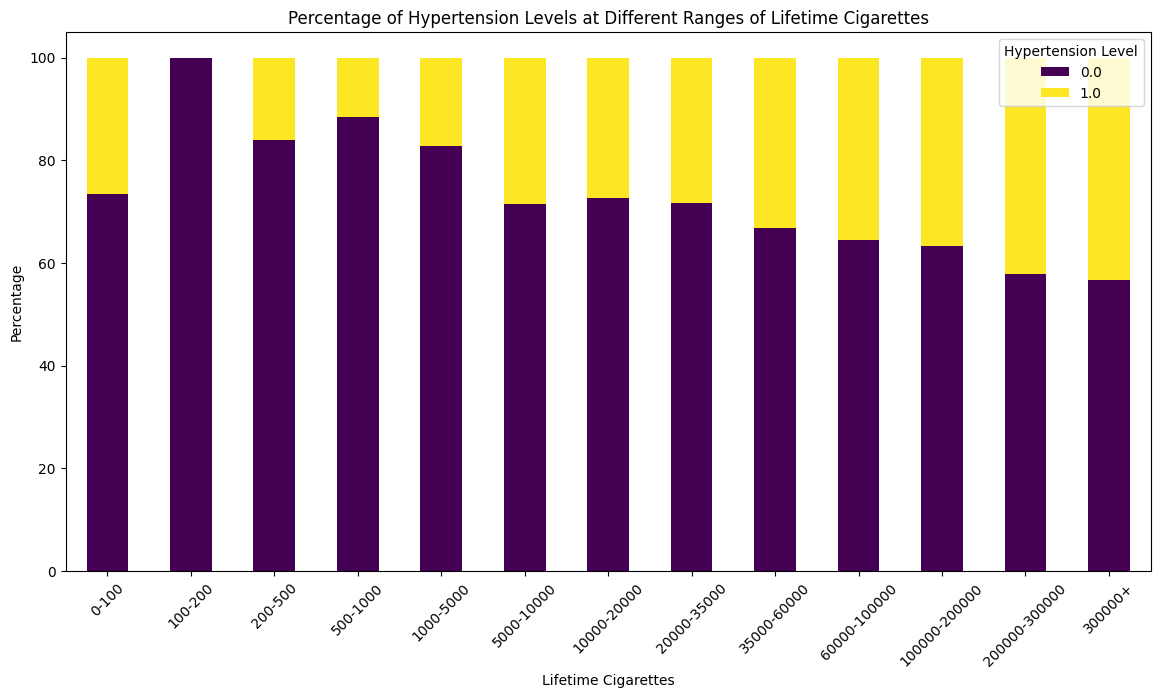

In [311]:
# Bin the lifetimeCigarettes values
bins = [0, 100, 200, 500, 1000, 5000, 10000, 20000, 35000, 60000, 100000, 200000, 300000, 1000000000000]
labels = ['0-100', '100-200', '200-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-35000', '35000-60000', '60000-100000', '100000-200000', '200000-300000', '300000+']
df['lifetimeCigarettesBinned'] = pd.cut(df['lifetimeCigarettes'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of lifetimeCigarettes
hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Lifetime Cigarettes')
plt.xlabel('Lifetime Cigarettes')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

In [312]:
def transform_alc_consump_freq(row):
    if row['UnitAlc'] == 1:
        return (row['AlcConsumpFreq'] * 52)
    elif row['UnitAlc'] == 2:
        return (row['AlcConsumpFreq'] * 12)
    else:
        if (row['AlcConsumpFreq'] > 365):
            return np.nan
        return row['AlcConsumpFreq']
    

df['AlcConsumpFreq'] = df.apply(transform_alc_consump_freq, axis=1)

In [313]:
# Set values in 'AlcConsumpAmtPerDrinkDay' to NaN where the condition is met
df.loc[df['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan

# Calculate the new column 'AlcConsump/Yr' by multiplying the relevant columns
df['AlcConsump/Yr'] = df['AlcConsumpAmtPerDrinkDay'] * df['AlcConsumpFreq']

In [314]:
#Combine vig and mod activity

df['ActivityLvl'] = df.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)

df['WeightedActivity'] = df.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

In [315]:
df.isnull().sum()

ID                                  0
Gender                              0
Age                                 0
EducationLvl                      324
DiasBP1                           286
DiasBP2                            93
DiasBP3                            88
SysBP1                            286
SysBP2                             93
SysBP3                             88
BMI                                61
Height                             52
Waist                             278
Weight                             49
Cholesterol                         0
SaltFreq                          442
Diabetes                            0
VigActivity                         0
ModActivity                         0
ALQ101                            439
AlcConsumpMoreThan4/5MostDays     443
AlcConsumpFreq                    445
UnitAlc                           970
AlcConsumpAmtPerDrinkDay          444
100Cigs                             0
Smoker                              0
OvrDietHealt

In [316]:
df = df.dropna(thresh=len(df) - 2000, axis=1)
df.isnull().sum()

ID                                 0
Gender                             0
Age                                0
EducationLvl                     324
DiasBP1                          286
DiasBP2                           93
DiasBP3                           88
SysBP1                           286
SysBP2                            93
SysBP3                            88
BMI                               61
Height                            52
Waist                            278
Weight                            49
Cholesterol                        0
SaltFreq                         442
Diabetes                           0
VigActivity                        0
ModActivity                        0
ALQ101                           439
AlcConsumpMoreThan4/5MostDays    443
AlcConsumpFreq                   445
UnitAlc                          970
AlcConsumpAmtPerDrinkDay         444
100Cigs                            0
Smoker                             0
OvrDietHealth                      0
G

In [317]:
df = df.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1', 
                      'SysBP2', 'SysBP3', 'AvgDiasBP', 'ALQ101', 'AlcConsumpMoreThan4/5MostDays', 
                      'UnitAlc', 'AlcConsumpAmtPerDrinkDay', '100Cigs', 'yearsSmokedBinned', 'lifetimeCigarettesBinned'])
null_values = df.isnull().sum()

In [318]:
df.head()

,Gender,Age,EducationLvl,BMI,Height,Waist,Weight,Cholesterol,SaltFreq,Diabetes,...,Smoker,OvrDietHealth,GenHealth,AvgSysBP,HypertensionLvl,yearsSmoked,lifetimeCigarettes,AlcConsump/Yr,ActivityLvl,WeightedActivity
0,1,69,3.0,26.7,171.3,100.0,78.3,1.0,4.0,1.0,...,3.0,2.0,2.0,112.666667,0.0,49.0,35770.0,1.0,0.0,0.0
1,1,54,3.0,28.6,176.8,107.6,89.5,1.0,3.0,1.0,...,2.0,3.0,4.0,157.333333,1.0,54.0,657.0,1456.0,0.0,0.0
2,1,72,4.0,28.9,175.3,109.2,88.9,1.0,2.0,1.0,...,3.0,3.0,3.0,142.000000,1.0,6.0,6570.0,0.0,0.5,1.0
4,2,73,5.0,19.7,162.4,NaN,52.0,2.0,4.0,2.0,...,3.0,2.0,5.0,137.333333,1.0,0.0,0.0,0.0,0.0,0.0
5,1,56,4.0,41.7,158.7,123.1,105.0,1.0,3.0,2.0,...,3.0,5.0,5.0,157.333333,1.0,22.0,40150.0,5.0,0.0,0.0


In [319]:
df = df.dropna()

In [320]:
# Define the conditions
conditions = (
    (df['Age'] < 45) &
    (df['BMI'] < 26) &
    (df['Waist'] < 130) &
    (df['yearsSmoked'] < 2) &
    (df['WeightedActivity'] > 0) &
    (df['HypertensionLvl'] > 0) &
    (df['AlcConsump/Yr'] < 200)
)

# Filter the DataFrame based on the conditions
filtered_df = df[conditions]

# Drop all rows that meet the conditions
df.drop(df[conditions].index, inplace=True)

In [321]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['yearsSmoked'] > 10) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [322]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['AlcConsump/Yr'] > 200) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [323]:
# Print the maximum values for all features
print("Maximum values for all features:")
print(df.max())

# Print the minimum values for all features
print("Minimum values for all features:")
print(df.min())

Maximum values for all features:
Gender                2.000000e+00
Age                   8.000000e+01
EducationLvl          9.000000e+00
BMI                   7.010000e+01
Height                2.026000e+02
Waist                 1.725000e+02
Weight                1.954000e+02
Cholesterol           9.000000e+00
SaltFreq              9.000000e+00
Diabetes              9.000000e+00
VigActivity           2.000000e+00
ModActivity           2.000000e+00
AlcConsumpFreq        3.650000e+02
Smoker                3.000000e+00
OvrDietHealth         9.000000e+00
GenHealth             5.000000e+00
AvgSysBP              2.286667e+02
HypertensionLvl       1.000000e+00
yearsSmoked           7.100000e+01
lifetimeCigarettes    1.560375e+06
AlcConsump/Yr         6.552000e+03
ActivityLvl           1.000000e+00
WeightedActivity      3.000000e+00
dtype: float64
Minimum values for all features:
Gender                  1.000000
Age                    20.000000
EducationLvl            1.000000
BMI            

In [324]:
# Set all rows with EducationLvl as 9 to 3
df.loc[df['EducationLvl'] == 9, 'EducationLvl'] = 3

# Set Cholesterol, SaltFreq, Diabetes, OvrDietHealth to their mode when they equal 9
for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth']:
    mode_value = df[column].mode()[0]
    df.loc[df[column] == 9, column] = mode_value

# Set YearsSmoked and LifetimeCigarettes to 0 if they are less than 0
df.loc[df['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df.loc[df['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0

In [325]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Print the first few rows of the scaled DataFrame to verify
print(df_scaled.head())

   Gender       Age  EducationLvl       BMI    Height     Waist    Weight  \
0     0.0  0.816667          0.50  0.225000  0.534226  0.380342  0.282036   
1     0.0  0.566667          0.50  0.258929  0.616071  0.445299  0.350705   
2     0.0  0.866667          0.75  0.264286  0.593750  0.458974  0.347026   
3     0.0  0.600000          0.75  0.492857  0.346726  0.577778  0.445739   
4     1.0  0.683333          1.00  0.385714  0.392857  0.472650  0.374617   

   Cholesterol  SaltFreq  Diabetes  ...  Smoker  OvrDietHealth  GenHealth  \
0          0.0  1.000000       0.0  ...     1.0           0.25       0.25   
1          0.0  0.666667       0.0  ...     0.5           0.50       0.75   
2          0.0  0.333333       0.0  ...     1.0           0.50       0.50   
3          0.0  0.666667       0.5  ...     1.0           1.00       1.00   
4          1.0  0.000000       0.5  ...     1.0           0.75       0.50   

   AvgSysBP  HypertensionLvl  yearsSmoked  lifetimeCigarettes  AlcConsump/

In [326]:
df_scaled = df_scaled.dropna()

null_values = df_scaled.isnull().sum()
print("Null values in each column:")

Null values in each column:


In [327]:
df_scaled.columns

Index(['Gender', 'Age', 'EducationLvl', 'BMI', 'Height', 'Waist', 'Weight',
       'Cholesterol', 'SaltFreq', 'Diabetes', 'VigActivity', 'ModActivity',
       'AlcConsumpFreq', 'Smoker', 'OvrDietHealth', 'GenHealth', 'AvgSysBP',
       'HypertensionLvl', 'yearsSmoked', 'lifetimeCigarettes', 'AlcConsump/Yr',
       'ActivityLvl', 'WeightedActivity'],
      dtype='object')

In [328]:
# Create the target variable
target = df_scaled['HypertensionLvl']

# Drop the HypertensionLvl column from the DataFrame
df_scaled = df_scaled.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity'])

In [329]:
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled, target, test_size=0.35, random_state=42)

# Print the shapes of the resulting splits to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", Y_train.shape)
print("Test target shape:", Y_test.shape)

Training set shape: (2921, 19)
Test set shape: (1573, 19)
Training target shape: (2921,)
Test target shape: (1573,)


In [330]:
def evaluate_model(model, X_train, X_test, Y_train, Y_test):
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Check if the model supports predict_proba (required for AUC)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    else:
        print("Model does not support probability predictions; AUC cannot be calculated.")
        y_pred_proba = None
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Accuracy: {accuracy:.5f}")

    # Create a DataFrame to compare predictions with actual results
    comparison_df = pd.DataFrame({
        'Actual': Y_test,
        'Predicted': y_pred
    })

    # Add predicted probabilities if available
    if y_pred_proba is not None:
        comparison_df['Predicted_Probability'] = y_pred_proba

    # Print the comparison DataFrame
    print("\nComparison DataFrame:")
    print(comparison_df.to_string())

    # Calculate AUC score if probabilities are available
    if y_pred_proba is not None:
        auc = roc_auc_score(Y_test, y_pred_proba)
        print(f"AUC Score: {auc:.5f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.5f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("AUC and ROC Curve cannot be plotted as the model does not provide probability estimates.")

Accuracy: 0.73617

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
157      1.0        0.0               0.143323
3564     0.0        0.0               0.363180
1482     1.0        1.0               0.615704
3277     0.0        0.0               0.107516
1018     0.0        0.0               0.050524
4015     0.0        0.0               0.106776
871      0.0        1.0               0.639943
944      0.0        0.0               0.124404
2765     0.0        0.0               0.136890
3178     0.0        0.0               0.435916
3727     0.0        0.0               0.384637
1871     0.0        1.0               0.519303
438      1.0        0.0               0.119461
457      1.0        1.0               0.716283
1644     0.0        0.0               0.081198
2994     0.0        0.0               0.053253
1837     1.0        1.0               0.592694
602      0.0        0.0               0.329436
2488     1.0        0.0               0.247753
2837     0.0       

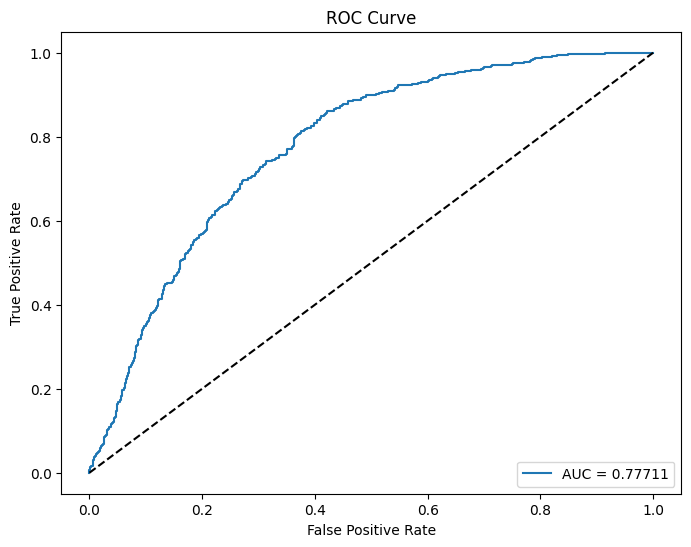

In [331]:
LR_model = LogisticRegression(max_iter=1000)
evaluate_model(LR_model, X_train, X_test, Y_train, Y_test)

Accuracy: 0.72600

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
157      1.0        0.0                   0.28
3564     0.0        0.0                   0.30
1482     1.0        1.0                   0.55
3277     0.0        0.0                   0.16
1018     0.0        0.0                   0.15
4015     0.0        0.0                   0.10
871      0.0        1.0                   0.58
944      0.0        0.0                   0.05
2765     0.0        0.0                   0.06
3178     0.0        1.0                   0.56
3727     0.0        1.0                   0.53
1871     0.0        0.0                   0.42
438      1.0        0.0                   0.18
457      1.0        1.0                   0.87
1644     0.0        0.0                   0.02
2994     0.0        0.0                   0.11
1837     1.0        0.0                   0.35
602      0.0        0.0                   0.20
2488     1.0        0.0                   0.43
2837     0.0       

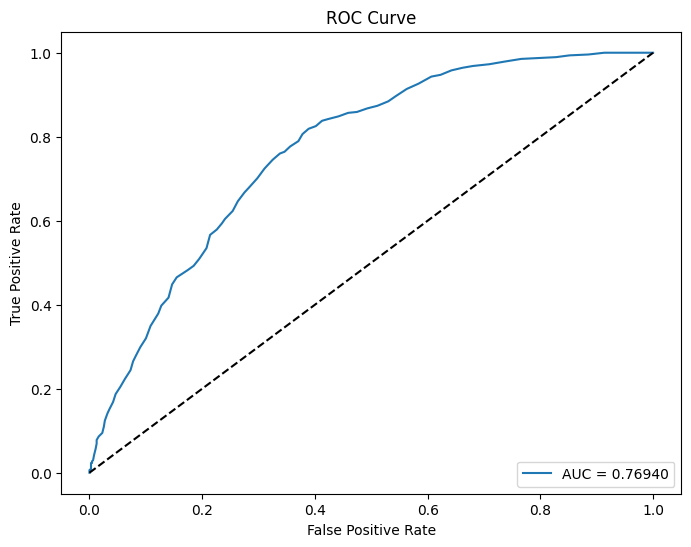

In [332]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(RF_model, X_train, X_test, Y_train, Y_test)

Accuracy: 0.73427

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
157      1.0        0.0               0.097593
3564     0.0        0.0               0.215448
1482     1.0        1.0               0.797167
3277     0.0        0.0               0.138886
1018     0.0        0.0               0.025479
4015     0.0        0.0               0.072762
871      0.0        1.0               0.694338
944      0.0        0.0               0.043042
2765     0.0        0.0               0.068634
3178     0.0        1.0               0.592670
3727     0.0        0.0               0.423395
1871     0.0        0.0               0.451580
438      1.0        0.0               0.074609
457      1.0        1.0               0.953796
1644     0.0        0.0               0.031097
2994     0.0        0.0               0.046359
1837     1.0        0.0               0.321960
602      0.0        0.0               0.179796
2488     1.0        0.0               0.281695
2837     0.0       

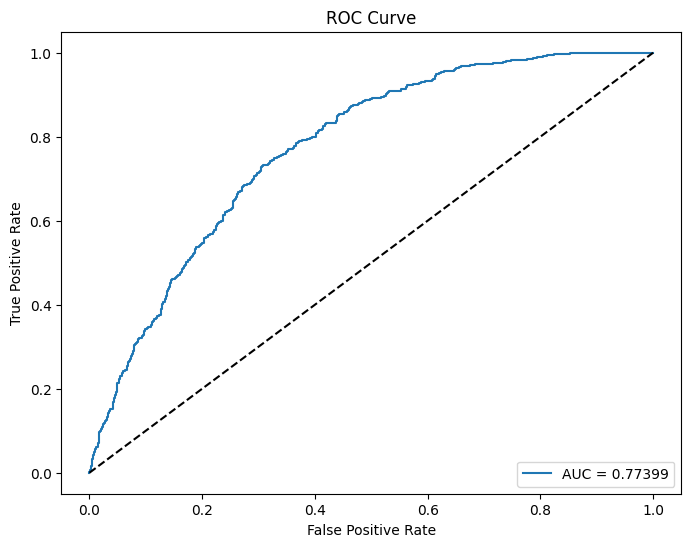

In [333]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())
evaluate_model(catboost_model, X_train, X_test, Y_train, Y_test)

In [334]:
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# Define the hyperparameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, Y_train)

# Get the best model from grid search
best_catboost_model = grid_search.best_estimator_

# Train the model with the best parameters
best_catboost_model.fit(X_train, Y_train)

# Evaluate the best model using the provided evaluate_model function
evaluate_model(best_catboost_model, X_train, X_test, Y_train, Y_test)

# Output best parameters
print("Best parameters found: ", grid_search.best_params_)